In [33]:
# -1-) Notlar
"""
    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.

    Yapilmasi gerekenler:
        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis
        - Farkli grafikler cikartmaya calis.
        - ML.
        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka
        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.

    Sorunlar:
        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun
        ortalamasi az olur. Burada farkli bir yontem bul.
        Gunluk maks min alinabilir
"""
# 1-) read and preproccess train.csv
# 2-) extract ilce and keep preprocessing train.csv
# 3-) read and preprocess weather.csv
# 4-) read and preprocess holidays.csv
# 5-) merge the train data and holidays, return a new dict called dict_holiday
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli ve gerekli degil)
# 10-) test icin birlestirme islemleri

"\n    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.\n\n    Yapilmasi gerekenler:\n        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis\n        - Farkli grafikler cikartmaya calis.\n        - ML.\n        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka\n        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.\n\n    Sorunlar:\n        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun\n        ortalamasi az olur. Burada farkli bir yontem bul.\n        Gunluk maks min alinabilir\n"

In [34]:
# 0-) Import required moduls and libraries

# bildirimisiz_sum tahmin edilecek

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import os
from unidecode import unidecode # to convert Turkish characters to English
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn import metrics
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Flatten 
from keras.layers import Dense 
from keras.layers import Activation
from keras.layers import LSTM
from keras import callbacks

In [35]:
# 1-) read and preproccess train.csv
train = pd.read_csv("./train.csv", low_memory=False) # 46.944 satir, 4 kolon

#print(train["tarih"]) # 1.098 farkli tarih var, 47 farkli ilce var

tarihler = []
for i in train["tarih"]:
    tarihler.append(datetime.strptime(i, "%Y-%m-%d"))
train["tarih"] = tarihler

# print(train.dtypes)

dict :{str, pd.DataFrame} = {} # key olarak ilceleri, value olarak o ilcenin verisi (1096 gun) df olarak tutar
for label, group in train.groupby("ilce"):
    dict[label] = group
print(dict["izmir-konak"])
ilceler = (list(dict.keys()))
#print(dict.keys()) # keys olarak her ilceyi, values olarak o ilcelerin bulundugu satirlari icerir

           tarih         ilce  bildirimsiz_sum  bildirimli_sum
19236 2021-01-01  izmir-konak                9               0
19237 2021-01-02  izmir-konak               20               0
19238 2021-01-03  izmir-konak                7               1
19239 2021-01-04  izmir-konak               16               1
19240 2021-01-05  izmir-konak                3               0
...          ...          ...              ...             ...
20355 2024-01-27  izmir-konak               12               3
20356 2024-01-28  izmir-konak               13               1
20357 2024-01-29  izmir-konak               22               0
20358 2024-01-30  izmir-konak               28               1
20359 2024-01-31  izmir-konak               16               0

[1124 rows x 4 columns]


In [36]:
# 2-) extract ilce and keep preprocessing train.csv
"""
for label in dict.keys(): # her ilce icin bildirimsiz ve bildirimli olarak grafiklerini cikart
    print(dict[label]["bildirimsiz_sum"])
    plt.figure(figsize=(14,6))
    plt.bar(dict[label]["tarih"],dict[label]["bildirimsiz_sum"])
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()
"""
"""
plt.figure(figsize=(14,6))
plt.bar(dict["izmir-konak"]["tarih"],dict["izmir-konak"]["bildirimsiz_sum"])
plt.title(label)
plt.margins(0.01)
plt.xticks(rotation=90)
plt.show()
"""
# ilce tarih sayilarini al hepsinde esit veri yok
ilce_tarih_sayilari = {}
for name in dict.keys():
    ilce_tarih_sayilari[name] = len(list(dict[name]["tarih"].to_dict().values()))

print(ilce_tarih_sayilari)
for name in dict.keys():
    dict[name].set_index("tarih", inplace=True)

# train.set_index("tarih", inplace=True) # train'in tarih kolonunu indexe cevir
# print(train)

{'izmir-aliaga': 1106, 'izmir-balcova': 698, 'izmir-bayindir': 1105, 'izmir-bayrakli': 1086, 'izmir-bergama': 1120, 'izmir-beydag': 673, 'izmir-bornova': 1124, 'izmir-buca': 1115, 'izmir-cesme': 1125, 'izmir-cigli': 1071, 'izmir-dikili': 1119, 'izmir-foca': 1086, 'izmir-gaziemir': 920, 'izmir-guzelbahce': 856, 'izmir-karabaglar': 1100, 'izmir-karaburun': 1089, 'izmir-karsiyaka': 1085, 'izmir-kemalpasa': 1118, 'izmir-kinik': 914, 'izmir-kiraz': 1097, 'izmir-konak': 1124, 'izmir-menderes': 1125, 'izmir-menemen': 1119, 'izmir-narlidere': 783, 'izmir-odemis': 1124, 'izmir-seferihisar': 1111, 'izmir-selcuk': 872, 'izmir-tire': 1107, 'izmir-torbali': 1124, 'izmir-urla': 1122, 'manisa-ahmetli': 622, 'manisa-akhisar': 1126, 'manisa-alasehir': 1119, 'manisa-demirci': 938, 'manisa-golmarmara': 566, 'manisa-gordes': 1059, 'manisa-kirkagac': 950, 'manisa-koprubasi': 805, 'manisa-kula': 1039, 'manisa-salihli': 1126, 'manisa-sarigol': 1027, 'manisa-saruhanli': 1105, 'manisa-sehzadeler': 1123, 'manis

In [37]:
# 3-) read and preprocess weather.csv

weather = pd.read_csv("./weather.csv", low_memory=False)
print(weather.columns) # onemli kolonlar: date, t_apparent:C (hissedilen sicaklik), wind_dir_10m:d (ruzgar yonu),
# wind_speed_10m:ms (ruzgar hizi), prob_precip_1h:p (yagis), ilce

# ilceleri ayir
ilce_weather = {} # keys olarak ilceleri, values olarak o ilcelerin saatlik (1165 gun) hava durumlarini tutar
for label, group in weather.groupby("name"):
    ilce_weather[label.lower()] = group

# tarihleri tarih formatina cevir
#print(ilce_weather["izmir-konak"].dtypes)
for name in ilce_weather.keys():

    tarihler = [] # duzenli tarihleri burada tut
    for date in ilce_weather[name]["date"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))

    ilce_weather[name]["date"] = tarihler # duzenli tarihleri date kolonuna ata
    ilce_weather[name].set_index("date", inplace=True) # tarihleri indexe cevir
    ilce_weather[name]["tarih"] = ilce_weather[name].index # tarih kolonunu tekrardan olustur

ilce_weather_day = {} # ilce hava durumu verilerini gunluk olarak tut (ortalama ile)
for name in ilce_weather.keys():
    ilce_weather_day[name] = ilce_weather[name].resample("D").mean(numeric_only=True)# index'teki tarihleri gune cevir
    ilce_weather_day[name]["tarih"] = ilce_weather_day[name].index

#print(ilce_weather["izmir-konak"]["tarih"])

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'name'],
      dtype='object')


In [38]:
print(ilce_weather_day["izmir-konak"].columns)

Index(['lat', 'lon', 't_2m:C', 'effective_cloud_cover:p', 'global_rad:W',
       'relative_humidity_2m:p', 'wind_dir_10m:d', 'wind_speed_10m:ms',
       'prob_precip_1h:p', 't_apparent:C', 'tarih'],
      dtype='object')


In [39]:
# 3.1-) her ilcenin hava durumunda her gununu ayri ayri df lere koyup dict te tut (runtime: 6m 35s)

ilce_weather_detailed = {} 
# {izmir-konak: {2021-01-01 : df , 2021-01-02 : df ,...} , manisa-akhisar: {2021-01-01 : df , 2021-01-02 : df ,...} }


for name in ilce_weather.keys():
    ilce_weather_detailed[name] = {}
    for label,group in ilce_weather[name].groupby("date"):

        gun = label.strftime('%Y-%m-%d')
        if gun in ilce_weather_detailed[name]:
            ilce_weather_detailed[name][gun] = pd.concat([ilce_weather_detailed[name][gun], group], ignore_index=True)
        else:
            ilce_weather_detailed[name][gun] = group.copy()


print((list(ilce_weather_detailed["izmir-konak"].keys())[0]))
print((list(ilce_weather_detailed["izmir-konak"].values())[0]).dtypes)

2021-01-01
lat                               float64
lon                               float64
t_2m:C                            float64
effective_cloud_cover:p           float64
global_rad:W                      float64
relative_humidity_2m:p            float64
wind_dir_10m:d                    float64
wind_speed_10m:ms                 float64
prob_precip_1h:p                  float64
t_apparent:C                      float64
name                               object
tarih                      datetime64[ns]
dtype: object


In [40]:
# 3.2-) 3.1'de ayrilan ilce gunlerini simdi her gun icin degerlerin min max'ini bulup ilce df'lerini tekrar olustur

# runtime: 1m 4s
weather_last = {} # key olarak ilceleri, value olarak da o ilcelerin hava durumu degerlerini min-max ile tutar
for name in ilce_weather_detailed.keys():
    weather_last[name] = pd.DataFrame()

    for date, day_df in ilce_weather_detailed[name].items():
        
        # max min leri al
        max_values = day_df.max()
        min_values = day_df.min()

        # satır oluştur
        new_row = pd.DataFrame({
            "Tarih": [datetime.strptime(date, "%Y-%m-%d")],
            "lat": [day_df["lat"].iloc[0]],
            "lon": [day_df["lon"].iloc[0]],
            "Sicaklik_max": [max_values["t_2m:C"]],
            "Sicaklik_min": [min_values["t_2m:C"]],
            "Bulutluluk_max": [max_values.get("effective_cloud_cover:p", None)],
            "Bulutluluk_min": [min_values.get("effective_cloud_cover:p", None)],
            "Guneslilik_max": [max_values.get("global_rad:W", None)],  
            "Guneslilik_min": [min_values.get("global_rad:W", None)],  
            "Bagil_nem_max": [max_values.get("relative_humidity_2m:p", None)],
            "Bagil_nem_min": [min_values.get("relative_humidity_2m:p", None)],
            "Ruzgar_yonu_max": [max_values.get("wind_dir_10m:d", None)],
            "Ruzgar_yonu_min": [min_values.get("wind_dir_10m:d", None)],
            "Ruzgar_hizi_max": [max_values.get("wind_speed_10m:ms", None)],
            "Ruzgar_hizi_min": [max_values.get("wind_speed_10m:ms", None)],
            "Yagis_max": [max_values.get("prob_precip_1h:p", None)],
            "Yagis_min": [min_values.get("prob_precip_1h:p", None)],
            "Hissedilen_sicaklik_max": [max_values.get("t_apparent:C", None)],
            "Hissedilen_sicaklik_min": [min_values.get("t_apparent:C", None)],
            "Ilce": [day_df["name"].iloc[0].lower()]  # Ilce ekle
        })

        # her gunu o ilcenin df ine ekle
        weather_last[name] = pd.concat([weather_last[name], new_row], ignore_index=True)

  
new_column_names = {
    "lat" : "lat", "lot" : "lot", "Sicaklik_max" : "Sicaklik_max", "Sicaklik_min" : "Sicaklik_min",
    "Bulutluluk_max" : "Bulutluluk_max", "Bulutluluk_min" : "Bulutluluk_min", "Guneslilik_max" : "Guneslilik_max",
    "Guneslilik_min" : "Guneslilik_min", "Bagil_nem_max" : "Bagil_nem_max", "Bagil_nem_min" : "Bagil_nem_min",
    "Ruzgar_yonu_max" : "Ruzgar_yonu_max", "Ruzgar_yonu_min" : "Ruzgar_yonu_min", "Ruzgar_hizi_max" : "Ruzgar_hizi_max",
    "Ruzgar_hizi_min" : "Ruzgar_hizi_min", "Yagis_max" : "Yagis_max", "Yagis_min" : "Yagis_min",
    "Hissedilen_sicaklik_max" : "Hissedilen_sicaklik_max", "Hissedilen_sicaklik_min" : "Hissedilen_sicaklik_min",
    "Ilce" : "Ilce", "t_2m:C" : "Sicaklik", "effective_cloud_cover:p" : "Bulutluluk", "global_rad:W" : "Guneslilik",
    "relative_humidity_2m:p" : "Bagil_nem", "wind_dir_10m:d" : "Ruzgar_yonu", "wind_speed_10m:ms" : "Ruzgar_hizi",
    "prob_precip_1h:p" : "Yagis", "t_apparent:C" : "Hissedilen_sicaklik", "Tarih" : "Tarih"
}

for name in weather_last.keys():
    weather_last[name].set_index("Tarih", inplace=True) # tarih kolonunu indexe ata
    weather_last[name]["Tarih"] = weather_last[name].index # tarih kolonunu tekrardan olustur

    weather_last[name] = pd.concat([weather_last[name], ilce_weather_day[name][["t_2m:C","effective_cloud_cover:p",
    "global_rad:W", "relative_humidity_2m:p","wind_dir_10m:d","wind_speed_10m:ms","prob_precip_1h:p",
    "t_apparent:C"]]], axis=1) # mean leri ekle
    
    weather_last[name] = weather_last[name].rename(columns=new_column_names) # kolonlari tekrar isimlendir
    

print(weather_last["izmir-konak"].head())

                lat      lon  Sicaklik_max  Sicaklik_min  Bulutluluk_max  \
2021-01-01  38.4177  27.1283          15.3          11.9            90.0   
2021-01-02  38.4177  27.1283          17.4          11.0            57.5   
2021-01-03  38.4177  27.1283          15.3          11.2            99.8   
2021-01-04  38.4177  27.1283          17.7          10.5            97.4   
2021-01-05  38.4177  27.1283          16.7          11.2            99.7   

            Bulutluluk_min  Guneslilik_max  Guneslilik_min  Bagil_nem_max  \
2021-01-01            28.2           275.4             0.0           93.5   
2021-01-02            10.4           374.0             0.0           90.9   
2021-01-03            12.4           151.9             0.0           84.6   
2021-01-04             9.2           357.0             0.0           85.6   
2021-01-05             5.4           362.3             0.0          100.0   

            Bagil_nem_min  ...         Ilce      Tarih   Sicaklik  Bulutluluk  \

In [41]:
print(weather_last["izmir-konak"].columns)

Index(['lat', 'lon', 'Sicaklik_max', 'Sicaklik_min', 'Bulutluluk_max',
       'Bulutluluk_min', 'Guneslilik_max', 'Guneslilik_min', 'Bagil_nem_max',
       'Bagil_nem_min', 'Ruzgar_yonu_max', 'Ruzgar_yonu_min',
       'Ruzgar_hizi_max', 'Ruzgar_hizi_min', 'Yagis_max', 'Yagis_min',
       'Hissedilen_sicaklik_max', 'Hissedilen_sicaklik_min', 'Ilce', 'Tarih',
       'Sicaklik', 'Bulutluluk', 'Guneslilik', 'Bagil_nem', 'Ruzgar_yonu',
       'Ruzgar_hizi', 'Yagis', 'Hissedilen_sicaklik'],
      dtype='object')


In [42]:
# 3.3-) K-means ile gunleri ozetleme


from sklearn.cluster import KMeans
for name in weather_last.keys():

    x = x = weather_last[name].drop(columns=["Ilce","Tarih"]).iloc[:, 3:].values
    #print(x)
    """
    wcss_list= []

    for i in range(1, 11):  

        kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  

        kmeans.fit(x)  

        wcss_list.append(kmeans.inertia_) 
    
    plt.plot(range(1, 11), wcss_list)  
    plt.title('The Elobw Method Graph')  
    plt.xlabel('Number of clusters(k)')  
    plt.ylabel('wcss_list')  
    plt.show()
    """
    # k = 3 or 7
    #training the K-means model on a dataset  

    kmeans = KMeans(n_clusters=4, init='k-means++', random_state= 42)  

    y_predict= kmeans.fit_predict(x)

    # kolona ekle
    weather_last[name]["Ozet"] = y_predict
    #print(weather_last[name].head())
    #visulaizing the clusters  
    """
    plt.figure(figsize=(14,6))
    plt.scatter(x[y_predict == 0, 0], x[y_predict == 0, 1], s = 100, c = 'blue', label = 'Cluster 1') #for first cluster  
    plt.scatter(x[y_predict == 1, 0], x[y_predict == 1, 1], s = 100, c = 'green', label = 'Cluster 2') #for second cluster  
    plt.scatter(x[y_predict== 2, 0], x[y_predict == 2, 1], s = 100, c = 'red', label = 'Cluster 3') #for third cluster  
    plt.scatter(x[y_predict == 3, 0], x[y_predict == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
    plt.scatter(x[y_predict == 4, 0], x[y_predict == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5') #for fifth cluster  
    #plt.scatter(x[y_predict == 5, 0], x[y_predict == 5, 1], s = 100, c = 'black', label = 'Cluster 6') #for fifth cluster  
    #plt.scatter(x[y_predict == 6, 0], x[y_predict == 6, 1], s = 100, c = 'gray', label = 'Cluster 7') #for fifth cluster  
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroid')
    plt.title('Clusters of customers')  
    plt.xlabel('Annual Income (k$)')  
    plt.ylabel('Spending Score (1-100)')  
    plt.legend()  
    plt.show()  """

c:\Users\Xesth\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Xesth\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Xesth\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\Xesth\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

In [43]:
# 4-) read and preprocess holidays.csv

holiday = pd.read_csv("./holidays.csv", low_memory=False)

# print(holiday.head())

holiday["tarih"] = holiday['Yıl'].astype(str) + '-' + holiday['Ay'].astype(str) + '-' + holiday['Gün'].astype(str)
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d')
holiday.set_index("tarih", inplace=True)
holiday = holiday.drop(columns=["Yıl", "Ay", "Gün"])

print(holiday.columns) # index olarak tarihi (YY-AA-GG), Bayram_Flag olarak da bayram ismini tutar

Index(['Tatil Adı'], dtype='object')


In [44]:
# 5-) merge the train data and holidays, return a new dict called dict_holiday

def merge_holiday(df1, df2=holiday):
    merged_df = pd.merge(df1, df2["Tatil Adı"], left_index=True, right_index=True, how="left")
    #df1["Bayramlar"] = df2["Bayram_Flag"]
    return merged_df

dict_holiday = {}
for name in dict.keys():
    dict_holiday[name] = merge_holiday(dict[name],holiday)
    dict_holiday[name]['tarih'] = dict_holiday[name].index
    dict_holiday[name] = dict_holiday[name].reindex(columns=["tarih", "ilce", "bildirimsiz_sum", "bildirimli_sum", "Tatil Adı"])
    
print(dict_holiday["izmir-konak"])

                tarih         ilce  bildirimsiz_sum  bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak               20               0   
2021-01-03 2021-01-03  izmir-konak                7               1   
2021-01-04 2021-01-04  izmir-konak               16               1   
2021-01-05 2021-01-05  izmir-konak                3               0   
...               ...          ...              ...             ...   
2024-01-27 2024-01-27  izmir-konak               12               3   
2024-01-28 2024-01-28  izmir-konak               13               1   
2024-01-29 2024-01-29  izmir-konak               22               0   
2024-01-30 2024-01-30  izmir-konak               28               1   
2024-01-31 2024-01-31  izmir-konak               16               0   

                 Tatil Adı  
tarih                       
2021-01-01  New Ye

In [45]:
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns

def merge_weather(df1, df2):
    merged_df = pd.merge(df1, df2[["Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min",
    "Sicaklik","Bagil_nem","Ruzgar_hizi","Yagis","Ozet"]], left_index=True, right_index=True, how="left")
    return merged_df

""" ekstra eklenebilecek kolonlar : (bunlari ustteki diger kolonarin arkasina ekleyebilirsin, ayni sekilde alttaki isimlendirmeye de eklemeyi unutma)
"Bulutluluk_max", "Bulutluluk_min", "Guneslilik_max", "Guneslilik_min","Ruzgar_yonu_max", "Ruzgar_yonu_min","Hissedilen_sicaklik_max", "Hissedilen_sicaklik_min"
,"Bulutluluk","Guneslilik","Ruzgar_yonu","Hissedilen_sicaklik"
"""
merged_all = {} # key olarak tum ilceler, values olarak kesintiler, bayramlar, hava durumu verilerini (1096 gun) tutan df'i tutar
for name in dict_holiday.keys():
    merged_all[name] = merge_weather(dict_holiday[name], weather_last[name])

    merged_all[name].columns = ["Tarih", "Ilce", "Bildirimsiz_sum", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik_max", "Sicaklik_min","Bagil_nem_max","Bagil_nem_min",
    "Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min","Sicaklik","Bagil_nem","Ruzgar_hizi","Yagis","Ozet"]
    
    merged_all[name]['Gün'] = range(1, len(merged_all[name]) + 1)

print(merged_all["izmir-konak"].head())

all_in_one = pd.concat(merged_all.values(), ignore_index=True) # tum ilceleri birlestir
#print("\nall_in_one: \n\n",all_in_one.dtypes)

merged_all_week = {}
for name in merged_all.keys():
    merged_all_week[name] = merged_all[name].resample("W").sum(numeric_only=True)
#print(merged_all_week["izmir-konak"])

merged_all_month = {}
for name in merged_all.keys():
    merged_all_month[name] = merged_all[name].resample("M").sum(numeric_only=True)
#print(merged_all_month)

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak               20               0   
2021-01-03 2021-01-03  izmir-konak                7               1   
2021-01-04 2021-01-04  izmir-konak               16               1   
2021-01-05 2021-01-05  izmir-konak                3               0   

               Bayram_Flag  Sicaklik_max  Sicaklik_min  Bagil_nem_max  \
tarih                                                                   
2021-01-01  New Year's Day          15.3          11.9           93.5   
2021-01-02             NaN          17.4          11.0           90.9   
2021-01-03             NaN          15.3          11.2           84.6   
2021-01-04             NaN          17.7          10.5           85.6   
2021-01-05             NaN          16.7          11.2          

C:\Users\Xesth\AppData\Local\Temp\ipykernel_16344\2656318892.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merged_all_month[name] = merged_all[name].resample("M").sum(numeric_only=True)


In [46]:
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi (runtime: 19s)

if not os.path.exists("graphs"):
    os.makedirs("graphs")
    print("images klasörü olustu")
if not os.path.exists("./graphs/bildirimli_siz"):
    os.makedirs("./graphs/bildirimli_siz")
    print("bildirimli_siz klasoru olustu")


# for name in merged_all_week.keys():
#     plt.figure(figsize=(17,8))
#     plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimsiz_sum"], label="Bildirimsiz")
#     plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimli_sum"], label="Bildirimli")
#     plt.xticks(rotation=90)
#     plt.title("{} Bildirimli Bildirimsiz (Haftalik)".format(name), fontweight="bold", fontsize=15)
#     plt.xlabel("Tarih", fontsize=13)
#     plt.ylabel("Kesinti Sayisi", fontsize=13)

#     plt.margins(0.01)
#     plt.legend()
#     plt.grid()
#     plt.subplots_adjust(bottom=0.15)
#     plt.tight_layout()
#     plt.savefig("./graphs/bildirimli_siz/{}.png".format(name))
    #plt.show()

In [47]:
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği (runtime: 18s)

if not os.path.exists("graphs"):
    os.makedirs("graphs")
    print("images klasörü olustu")
if not os.path.exists("./graphs/bildirimsiz_detailed"):
    os.makedirs("./graphs/bildirimsiz_detailed")
    print("bildirimsiz_detailed klasoru olustu")

# for name in merged_all_week.keys():

    # plt.figure(figsize=(17,8))
    # plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimsiz_sum"], label="Bildirimsiz")
    # plt.title("{} - Bildirimsiz (Haftalik)".format(name), fontweight="bold", fontsize=15)
    # plt.xticks(rotation=90)
    # plt.xlabel("Tarih", fontsize=13)
    # plt.ylabel("Kesinti Sayisi", fontsize=13)

    # window_size = 3  # Hareketli ortalama penceresi
    # merged_all_week[name]['Moving_Average'] = merged_all_week[name]["Bildirimsiz_sum"].rolling(window=window_size, center=True).mean()
    # #plt.plot(merged_all_week[name]['Moving_Average'], label="MHO", color="black")

    # ortalama = merged_all_week[name]["Bildirimsiz_sum"].mean()
    # plt.axhline(y=ortalama, color='orange', linestyle='--', label='Ortalama %{:.1f}'.format(ortalama),linewidth=2.2)
    # alpha = 0.2  # Yumuşatma parametresi 
    # # formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
    # merged_all_week[name]['EWMA'] = merged_all_week[name]["Bildirimsiz_sum"].ewm(alpha=alpha, adjust=False).mean()

    # plt.plot(merged_all_week[name]['EWMA'], label="EWMA", color="red", lw=2.9)


    # plt.margins(0.01)
    # plt.legend()
    # plt.grid()
    # plt.subplots_adjust(bottom=0.15)
    # plt.tight_layout()
    # plt.savefig("./graphs/bildirimsiz_detailed/{}.png".format(name))
    #plt.show()

"""
ayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=4)

analiz = pd.concat([
    ayristirma2.observed,
    ayristirma2.trend,
    ayristirma2.seasonal,
    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey
], axis=1)
analiz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]

indeks = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 1)


X = sa.add_constant(indeks)
model = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)
sonuc = model.fit()
rsquared_value = sonuc.rsquared
y = pd.date_range(analiz.index[-1] + pd.DateOffset(weeks=4), periods=4,freq="W") # 4 tane ekstra ay ekle

yeni_satirlar = pd.DataFrame(index=y)
analiz = pd.concat([analiz, yeni_satirlar])

# not: bu degerleri ayarla
mev = [
    1.038656,
    0.973940,
    0.987404,
    1.038656
]

nan_indices = analiz.index[analiz['Mevsimsellik'].isna()]
for i, index in enumerate(nan_indices):
    if i < len(mev):
        analiz.at[index, 'Mevsimsellik'] = mev[i]
#print(analiz["Mevsimsellik"])

girdi = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 5)
regmodel = sonuc.predict(sa.add_constant(girdi))

analiz["Tahmin"] = analiz["Mevsimsellik"] * regmodel


print(analiz.head())

plt.text(analiz.index[0], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top')
#plt.text(analiz.index[-1], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top', horizontalalignment='left')
plt.scatter(analiz.index, analiz["Mevsimsellik Düzeltme"], label="Mevsimsellik Düzeltme", color="blue")
#plt.plot(analiz["Orijinal Gözlem"], label="Orijinal Gözlem", color="purple")
plt.plot(analiz.index, analiz["Tahmin"], label="Trend", color="red")
"""

'\nayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=4)\n\nanaliz = pd.concat([\n    ayristirma2.observed,\n    ayristirma2.trend,\n    ayristirma2.seasonal,\n    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey\n], axis=1)\nanaliz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]\n\nindeks = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 1)\n\n\nX = sa.add_constant(indeks)\nmodel = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)\nsonuc = model.fit()\nrsquared_value = sonuc.rsquared\ny = pd.date_range(analiz.index[-1] + pd.DateOffset(weeks=4), periods=4,freq="W") # 4 tane ekstra ay ekle\n\nyeni_satirlar = pd.DataFrame(index=y)\nanaliz = pd.concat([analiz, yeni_satirlar])\n\n# not: bu degerleri ayarla\nmev = [\n    1.038656,\n    0.973940,\n    0.987404,\n    1.038656\n]\n\nnan_indices = analiz.index[analiz[\'Mevsimsellik\'].isna()]\nfor i, index in enume

In [48]:
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli, gerekli degil)

yagis_dict = {}
for label,group in merged_all_week["izmir-aliaga"].groupby("Yagis_max"):
    yagis_dict[label] = group

yagis_dict_toplamlari = {}
for deger in yagis_dict.keys():
    yagis_dict_toplamlari[deger] = yagis_dict[deger]["Bildirimsiz_sum"].mean()
print(yagis_dict_toplamlari)

hesaplamalar = pd.DataFrame(list(yagis_dict_toplamlari.items()), columns=['Ort. Yagis', 'Ort. Kesinti'])
print(hesaplamalar)
window_size = 3  # Hareketli ortalama penceresi
hesaplamalar['Moving_Average'] = hesaplamalar["Ort. Kesinti"].rolling(window=window_size, center=True).mean()

alpha = 0.3  # Yumuşatma parametresi 
# formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
hesaplamalar['EWMA'] = hesaplamalar["Ort. Kesinti"].ewm(alpha=alpha, adjust=False).mean()


# plt.figure(figsize=(14,6))
# #plt.bar(merged_all_week["izmir-aliaga"]["Yagis"],merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=0.05, label="Bildirimsiz")
# plt.scatter(yagis_dict_toplamlari.keys(), yagis_dict_toplamlari.values(), label="Ort. Kesinti")
# #plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['Moving_Average'], label="MHO", color="red")
# plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['EWMA'], label="EWMA", color="red")
# plt.margins(0.01)
# plt.title("Izmir_Aliaga Yagis - Bildirimsiz (Haftalik)")
# plt.xticks(rotation=90)
# plt.xlabel("Ortalama Yagis Miktari")
# plt.ylabel("Ortalama Elektrik Kesintisi")
# plt.legend()
# plt.show()

{5.0: 30.0, 6.0: 26.285714285714285, 7.0: 34.170212765957444, 8.2: 31.0, 8.5: 36.0, 8.6: 34.0, 8.9: 37.0, 10.3: 26.0, 11.6: 26.0, 12.7: 35.0, 16.6: 37.0, 18.2: 44.0, 18.9: 28.0, 20.7: 35.0, 22.1: 26.0, 23.7: 33.0, 27.7: 25.0, 28.8: 52.5, 29.0: 32.0, 41.3: 35.0, 44.0: 69.0, 44.3: 27.0, 52.6: 22.0, 54.3: 32.0, 54.5: 13.0, 55.0: 20.0, 56.5: 18.0, 57.2: 43.0, 58.5: 37.0, 60.0: 44.0, 60.1: 28.0, 61.6: 29.0, 67.1: 32.0, 69.3: 45.0, 73.1: 22.0, 73.7: 32.0, 77.0: 61.0, 80.7: 41.0, 85.5: 23.0, 88.3: 38.0, 88.4: 37.0, 91.3: 49.0, 98.6: 72.0, 99.9: 41.0, 100.8: 54.0, 101.0: 31.0, 101.3: 27.0, 102.4: 28.0, 102.9: 18.0, 104.2: 40.0, 105.8: 53.0, 106.6: 30.0, 107.8: 20.0, 108.7: 35.0, 120.2: 40.0, 120.4: 28.0, 122.3: 31.0, 125.6: 54.0, 127.6: 39.0, 139.2: 53.0, 141.70000000000002: 35.0, 143.8: 68.0, 154.6: 27.0, 157.2: 41.0, 157.60000000000002: 31.0, 159.3: 47.0, 162.0: 58.0, 164.8: 32.0, 174.4: 29.0, 175.5: 37.0, 175.7: 33.0, 178.0: 27.0, 178.5: 53.0, 178.6: 60.0, 179.1: 53.0, 180.0: 30.0, 180.6: 2

In [49]:
# 10-) test icin birlestirme islemleri

test = pd.read_csv("./test.csv", low_memory=False) # 47 ilce icin 28 gunluk veriler var. (tarih, ilce, bildirimli_sum)
#print(test)

dict_test :{str, pd.DataFrame} = {} # key olarak ilceleri, value olarak ilcelerin 4 ocak - 31 ocak arasi verilerini df olarak tutar
for label, group in test.groupby("ilce"):
    dict_test[label] = group

print(dict_test["izmir-konak"].head())

for name in dict_test.keys():

    tarihler = [] # duzgun tarihleri tutacak
    for date in dict_test[name]["tarih"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d")) 

    dict_test[name]["tarih"] = tarihler # duzeltilmis tarihleri ata

    dict_test[name].set_index("tarih", inplace=True) # tarih kolonunu index'e ata
    dict_test[name]["Tarih"] = dict_test[name].index # tarih kolonunu yeniden olustur
    dict_test[name] = dict_test[name].iloc[:, [2, 0, 1]] # kolon siralarini duzenle
    dict_test[name].columns = ["Tarih", "Ilce", "Bildirimli_sum"] # kolon isimlerini duzenle

print(dict_test["izmir-konak"].columns)


dict_test_merged = {} # birlestirilenleri tutacak dict
for name in dict_test.keys():

    gecici = merge_holiday(dict_test[name], holiday) # test'e holiday ekle
    dict_test_merged[name] = merge_weather(gecici, weather_last[name]) # sonra weather'i ekle

    dict_test_merged[name].columns = ["Tarih", "Ilce", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik_max", "Sicaklik_min","Bagil_nem_max","Bagil_nem_min",
    "Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min","Sicaklik","Bagil_nem","Ruzgar_hizi","Yagis","Ozet"]

    dict_test_merged[name]['Gün'] = range(1, len(dict_test_merged[name]) + 1) # gun kolonu ekle (1-28 arasi oluyor)

print(dict_test_merged["izmir-konak"])


          tarih         ilce  bildirimli_sum
18   2024-02-01  izmir-konak               4
65   2024-02-02  izmir-konak               1
112  2024-02-03  izmir-konak               1
159  2024-02-04  izmir-konak               0
206  2024-02-05  izmir-konak               2
Index(['Tarih', 'Ilce', 'Bildirimli_sum'], dtype='object')
                Tarih         Ilce  Bildirimli_sum Bayram_Flag  Sicaklik_max  \
tarih                                                                          
2024-02-01 2024-02-01  izmir-konak               4         NaN          11.9   
2024-02-02 2024-02-02  izmir-konak               1         NaN          12.8   
2024-02-03 2024-02-03  izmir-konak               1         NaN          12.5   
2024-02-04 2024-02-04  izmir-konak               0         NaN          13.4   
2024-02-05 2024-02-05  izmir-konak               2         NaN          17.6   
2024-02-06 2024-02-06  izmir-konak               1         NaN          20.2   
2024-02-07 2024-02-07  izmir-ko

MAKINE OGRENMESI

Sequential() specifies that the network is a linear stack of layers

model.add() adds the hidden layer.

Dense means that neurons between layers are fully connected

input_dim defines the number of features in the training dataset

activation defines the activation function

loss selects the cost function

optimizer selects the learning algorithm

metrics selects the performance metrics to be saved for further analysis

model.fit() initialize the training

In [50]:
for df in dict_test_merged.values():
    df.rename(columns={'bildirimli_sum': 'Bildirimli_sum'}, inplace=True)

Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_518 (Dense)           (None, 64)                1024      
                                                                 
 dropout_235 (Dropout)       (None, 64)                0         
                                                                 
 dense_519 (Dense)           (None, 64)                4160      
                                                                 
 dense_520 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
23/23 [==============================] - 1s 11ms/step - loss: 42.4612 - mae: 5.0390 - val_loss: 31.8015 - val_mae: 4.0163
Epoch 2/60
23/23 [==============================]

c:\Users\Xesth\anaconda3\envs\tf_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Epoch 1/60
23/23 [==============================] - 1s 11ms/step - loss: 94.4942 - mae: 8.0257 - val_loss: 81.4726 - val_mae: 7.2513
Epoch 2/60
23/23 [==============================] - 0s 3ms/step - loss: 62.4165 - mae: 5.8577 - val_loss: 43.1878 - val_mae: 4.6567
Epoch 3/60
23/23 [==============================] - 0s 3ms/step - loss: 33.2159 - mae: 4.0978 - val_loss: 28.6635 - val_mae: 4.1528
Epoch 4/60
23/23 [==============================] - 0s 3ms/step - loss: 29.5150 - mae: 4.0086 - val_loss: 28.1721 - val_mae: 3.9597
Epoch 5/60
23/23 [==============================] - 0s 3ms/step - loss: 29.2280 - mae: 3.8825 - val_loss: 28.0369 - val_mae: 3.9371
Epoch 6/60
23/23 [==============================] - 0s 3ms/step - loss: 28.8311 - mae: 3.8770 - val_loss: 27.7923 - val_mae: 3.9479
Epoch 7/60
23/23 [==============================] - 0s 3ms/step - loss: 28.9556 - mae: 3.9332 - val_loss: 27.7342 - val_mae: 3.9223
Epoch 8/60
23/23 [==============================] - 0s 3ms/step - loss: 28.

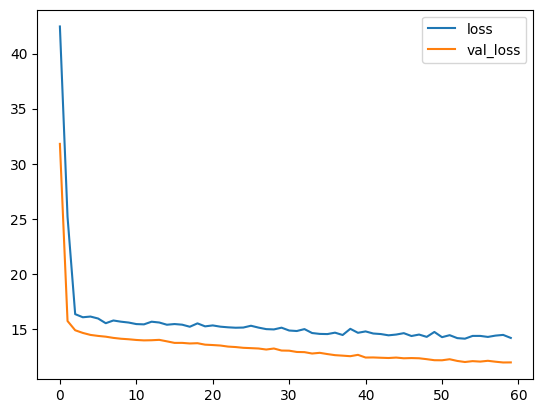

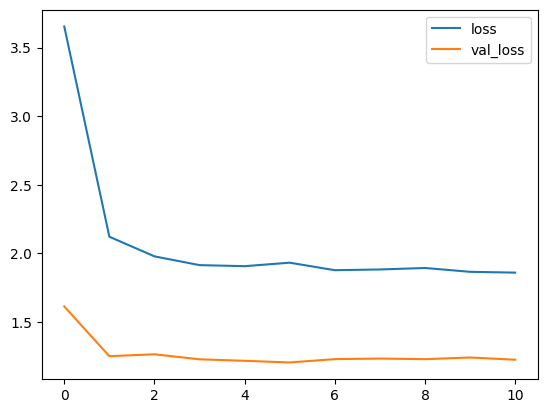

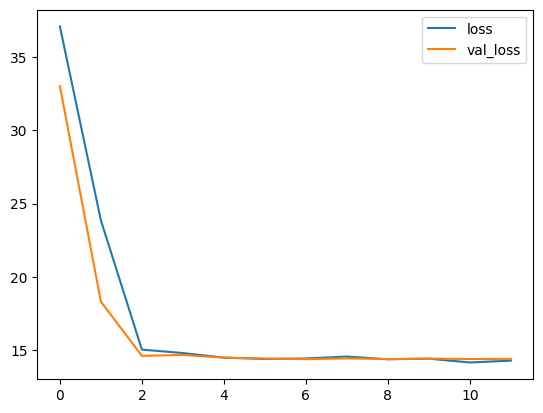

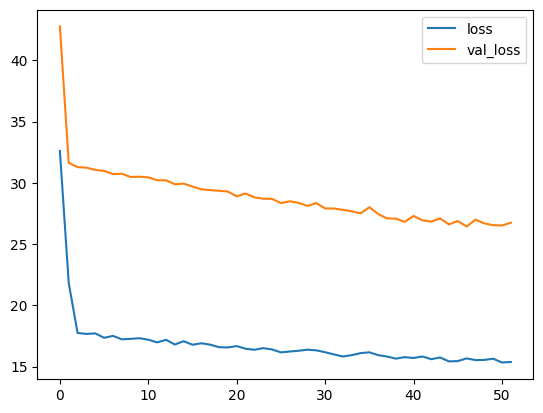

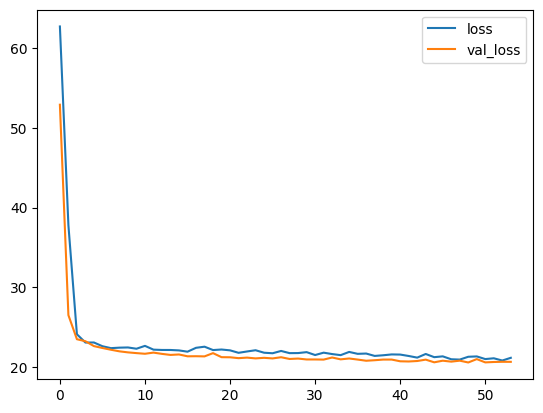

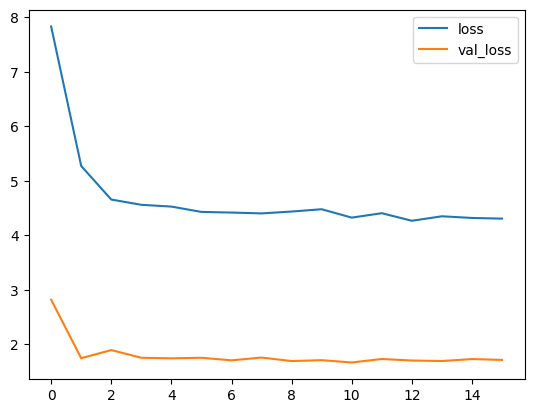

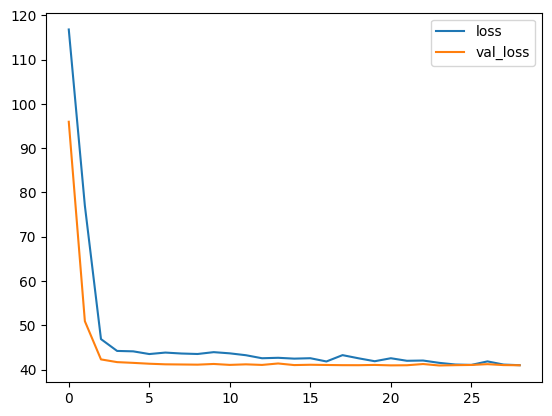

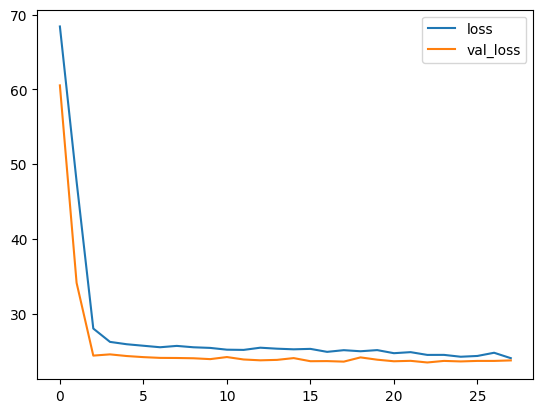

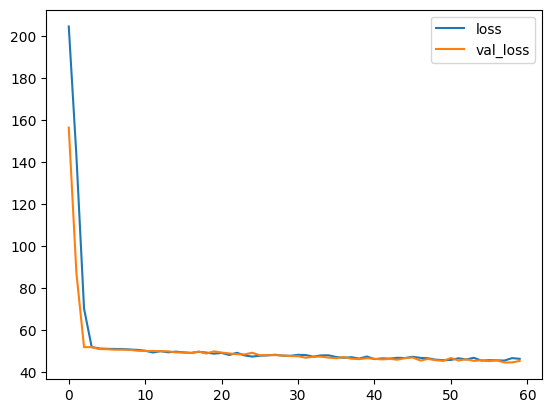

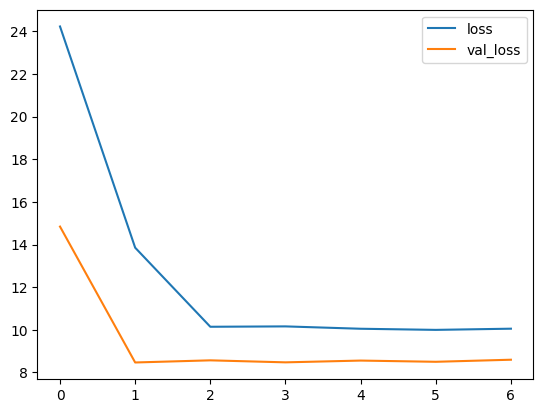

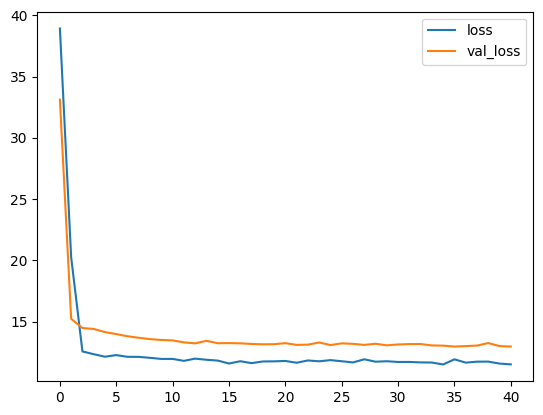

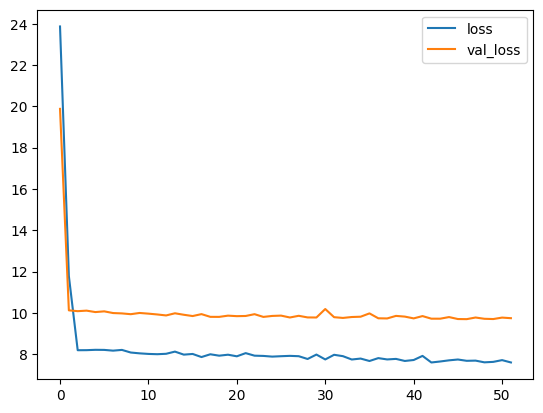

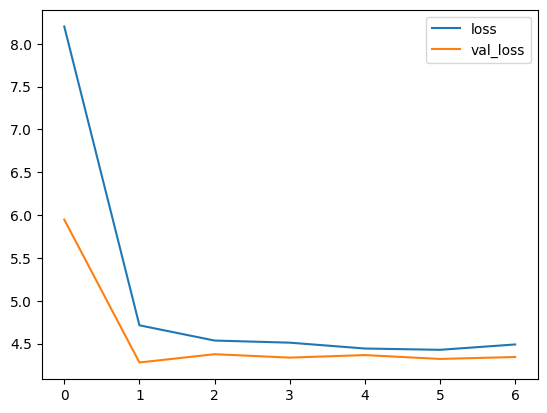

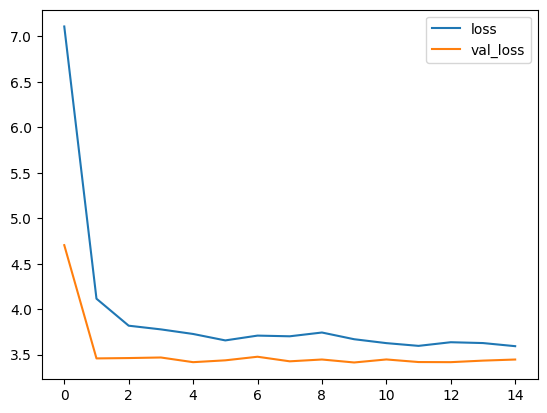

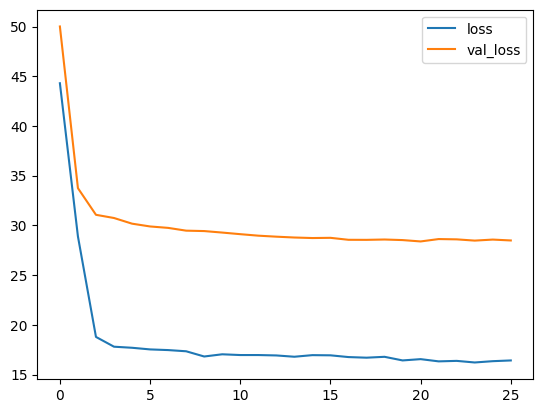

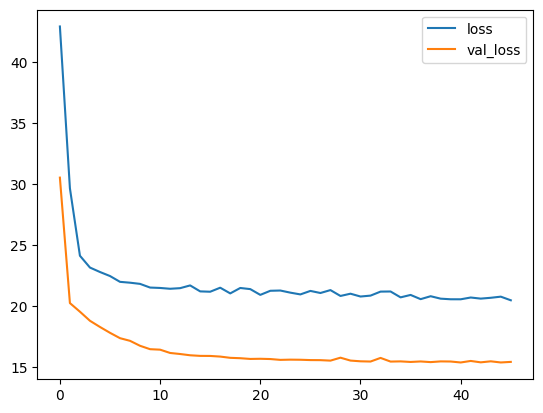

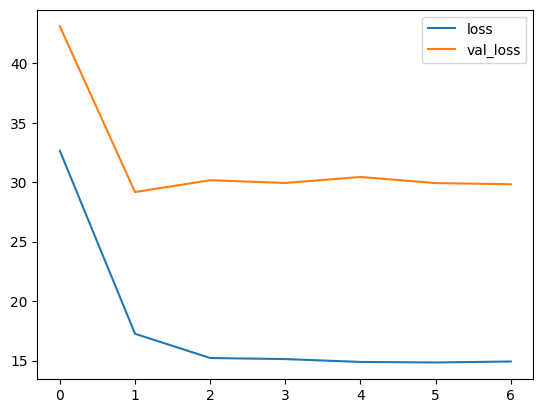

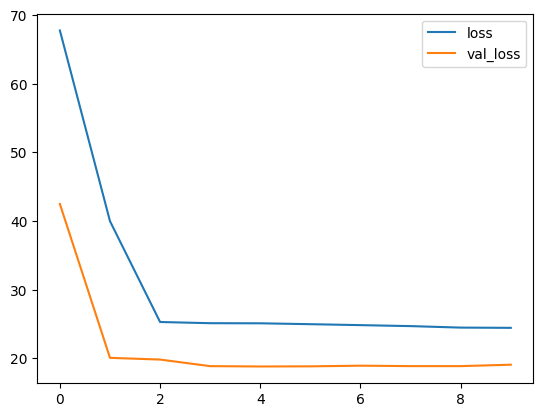

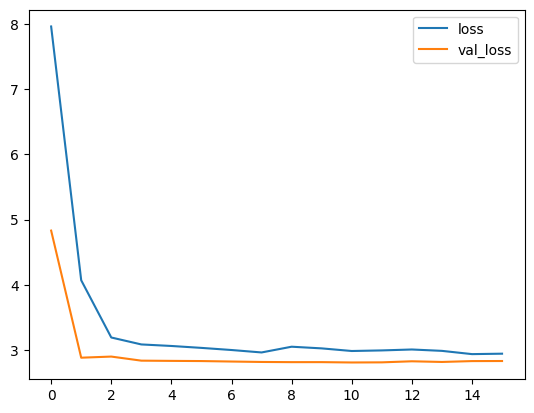

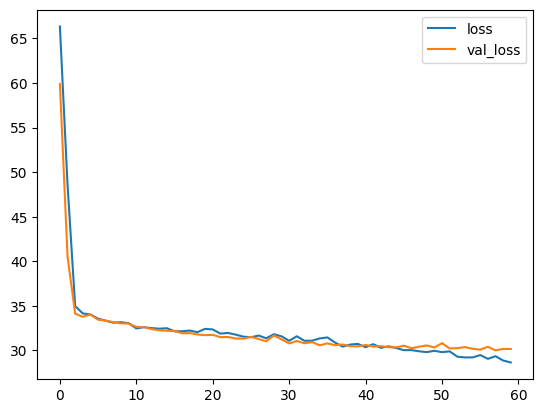

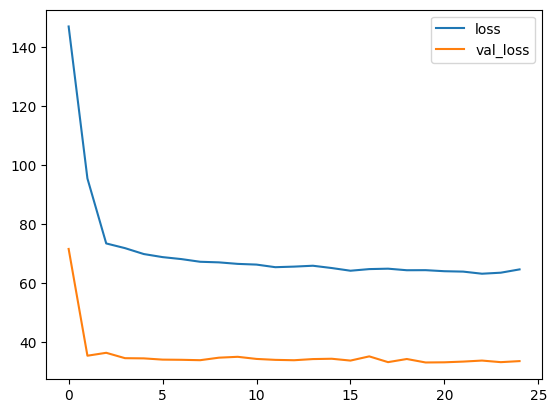

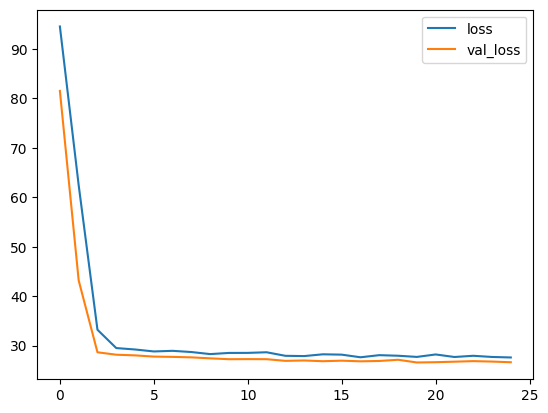

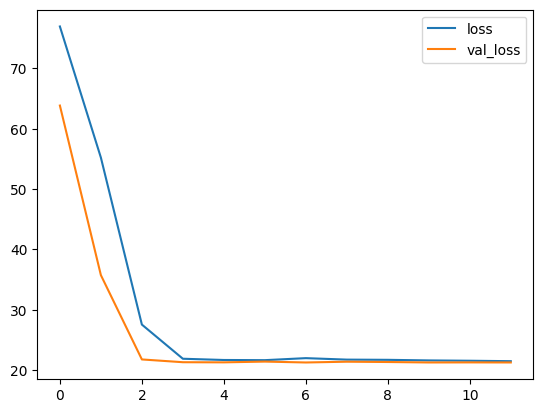

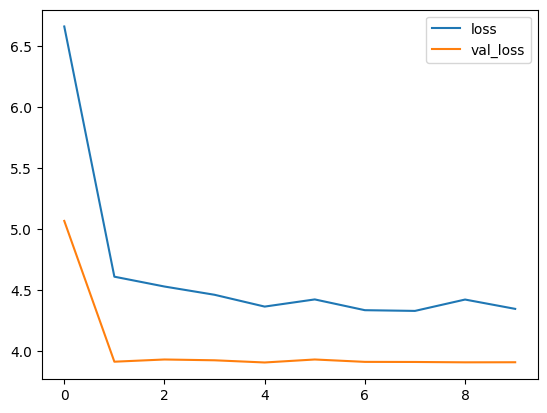

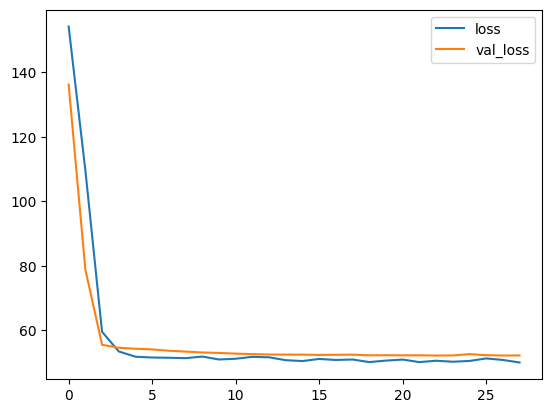

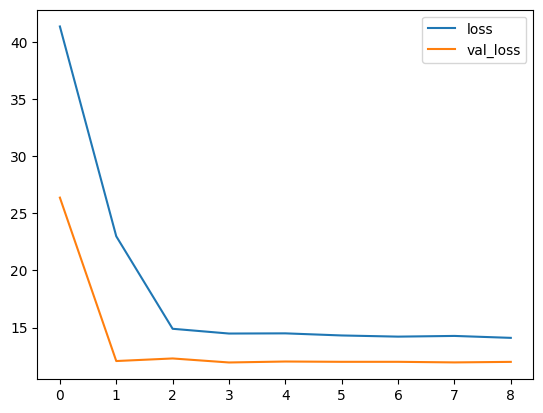

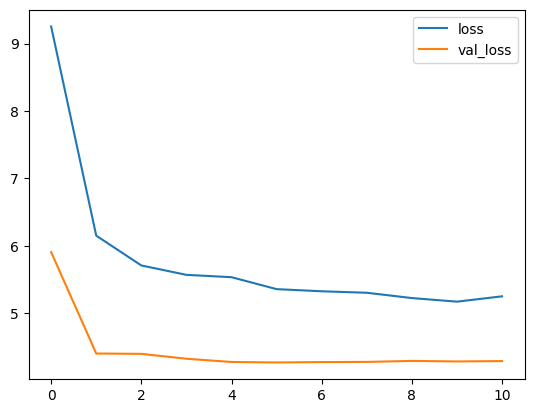

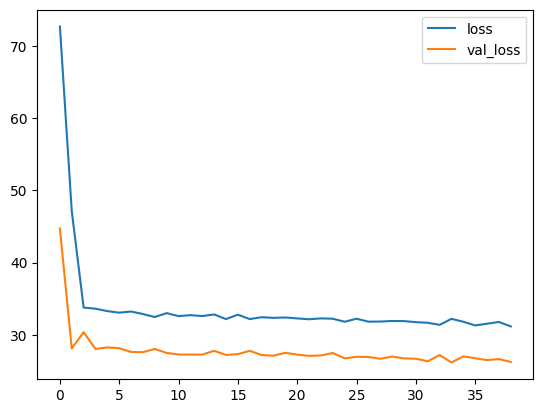

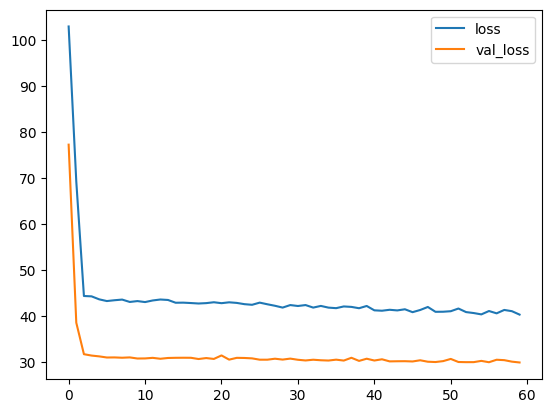

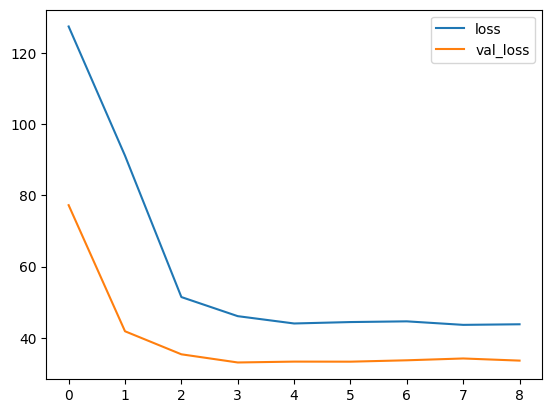

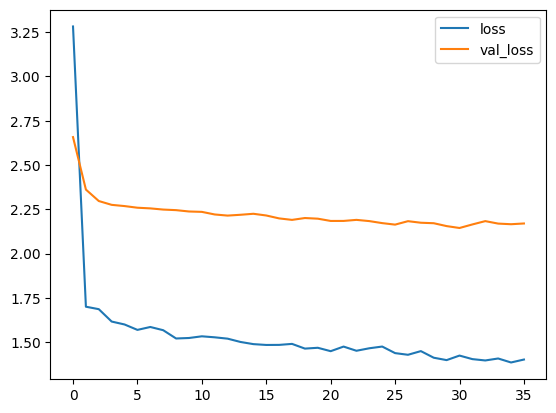

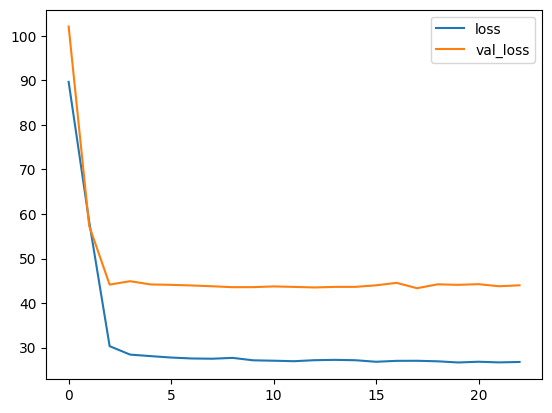

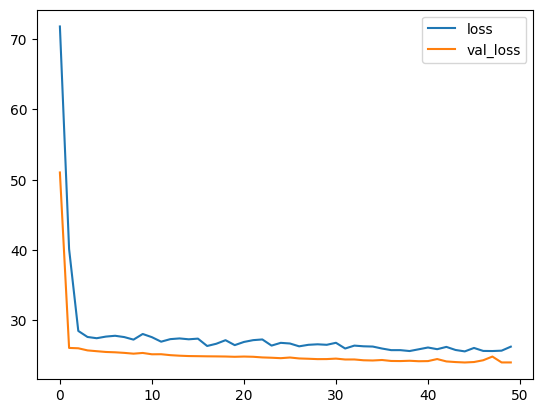

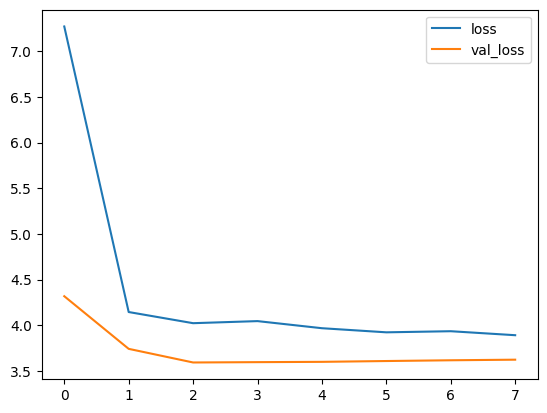

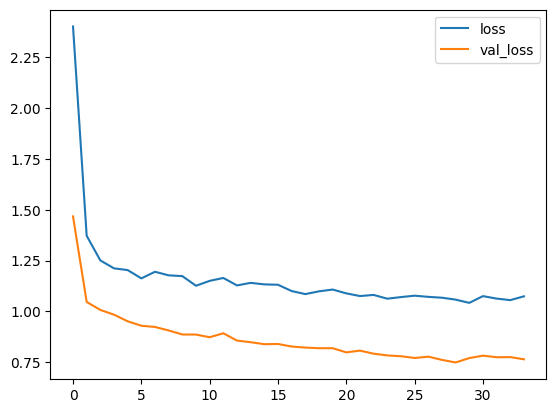

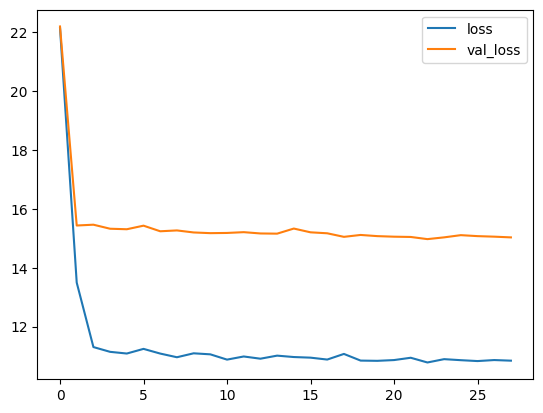

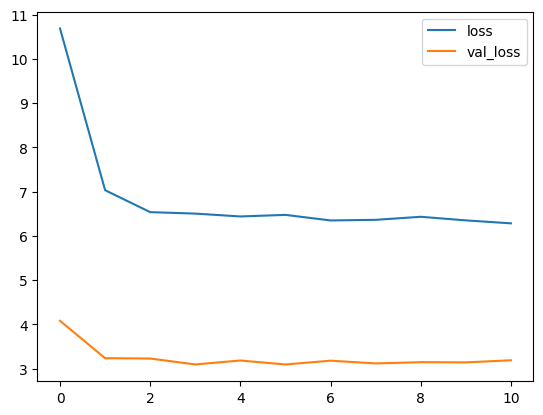

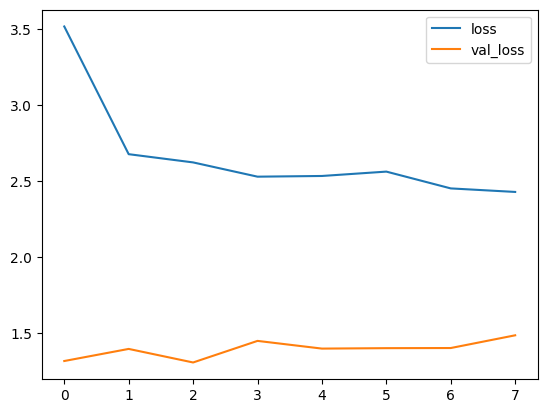

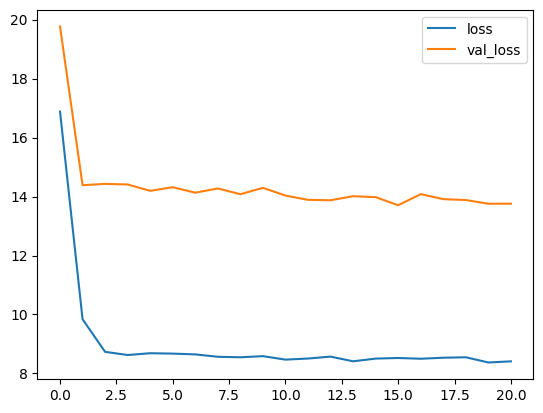

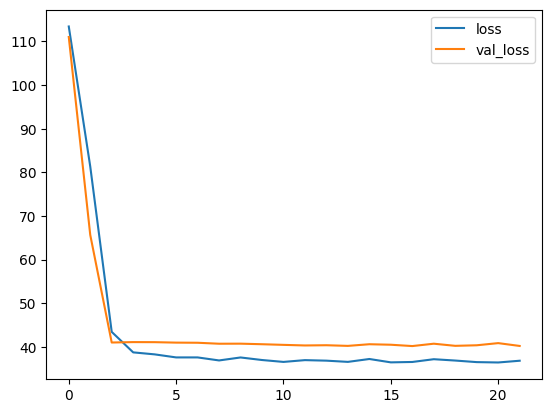

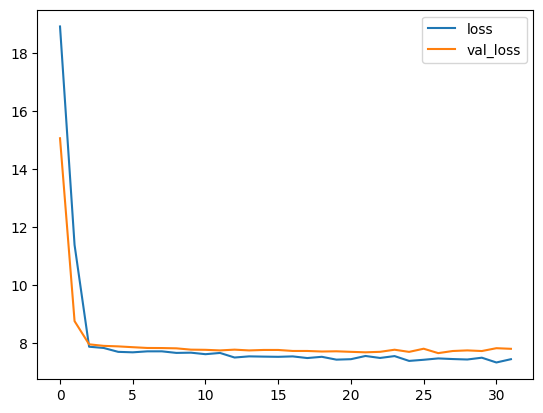

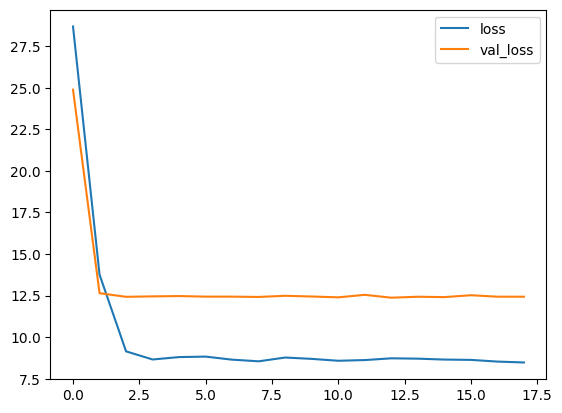

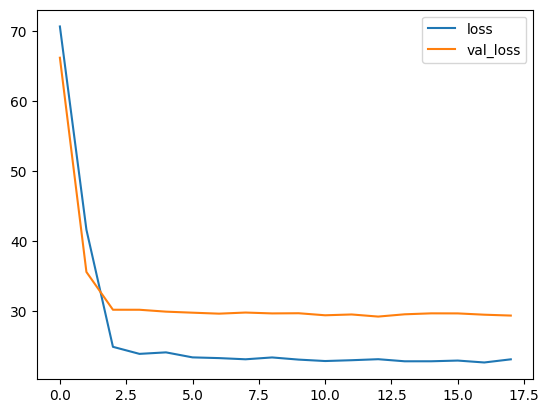

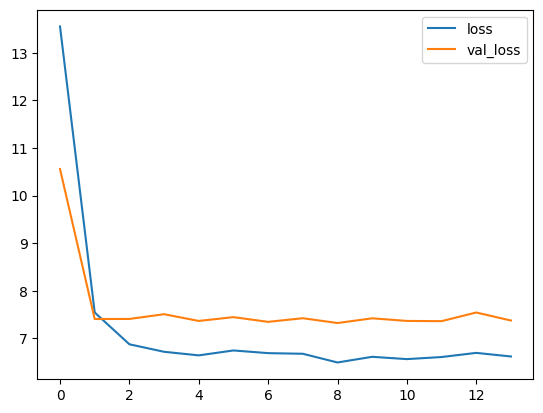

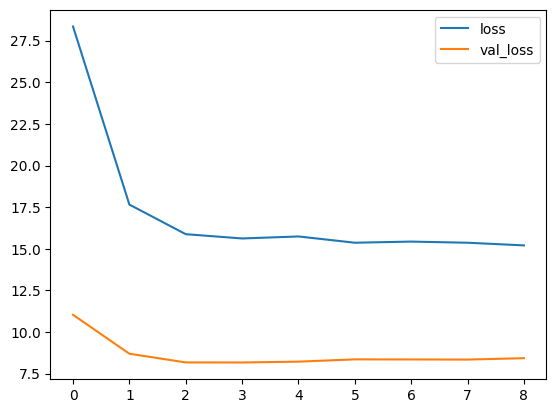

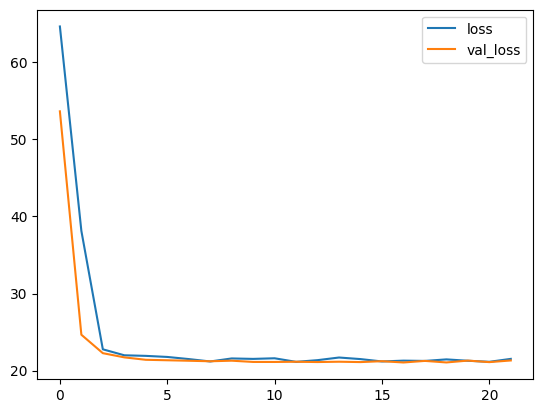

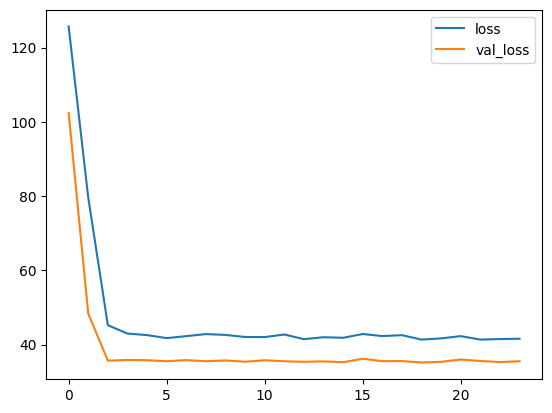

In [55]:
#merged_all[]
# all_in_one
df = merged_all
df_test = dict_test_merged
features = ['Bildirimli_sum','Sicaklik','Bayram_Flag','Bagil_nem','Ruzgar_hizi','Yagis',"Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min",'Ozet']
features_gun = ['Bildirimli_sum','Sicaklik','Bayram_Flag','Bagil_nem','Ruzgar_hizi','Yagis','Gün',"Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min",'Ozet']
features_bayramsiz = ['Bildirimli_sum','Sicaklik','Bagil_nem','Ruzgar_hizi','Yagis',"Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min",'Ozet']
features_output = ['Bildirimli_sum','Bildirimsiz_sum','Sicaklik','Bayram_Flag','Bagil_nem','Ruzgar_hizi','Yagis',"Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min",'Ozet']
output_var = df
target = 'Bildirimsiz_sum'
# ilceler = []

# NN 3
# ilceler = ['izmir-konak','izmir-kinik']
all_submissions = []
for ilce in ilceler:
    df = merged_all[ilce]
    df_test = dict_test_merged[ilce]
    output_var = df['Bildirimsiz_sum']

    # ilcelerin numerizasyonu
    columns_tonumerate = ['Bayram_Flag']
    for column in columns_tonumerate:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])

    # test csv dosyasi numerizasyon
    for column in columns_tonumerate:
        encoder = LabelEncoder()
        df_test[column] = encoder.fit_transform(df_test[column])

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(df[features])
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
    feature_transform_gun = scaler.fit_transform(df[features_gun])
    feature_transform_gun = pd.DataFrame(columns=features_gun, data=feature_transform_gun, index=df.index)
    scaler2 = MinMaxScaler()
    feature_test = scaler2.fit_transform(df_test[features])
    feature_test = pd.DataFrame(columns=features, data=feature_test, index=df_test.index)



    X = feature_transform
    y = output_var

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

    model = tf.keras.Sequential([
        # tf.keras.layers.Flatten(input_shape=(len(features))),
        tf.keras.layers.Dense(64, activation='relu',input_shape=(len(features),)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # model = tf.keras.Sequential([
    # tf.keras.layers.Dense(128, activation='relu', input_shape=(len(features),)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(1)
    # ])
    model.summary()


    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mae'])

    earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

    losses = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks=[earlystopping])

    loss, mae = model.evaluate(X_test, y_test)
    print("Mean Absolute Error on Test Data:", mae)

    predictions = model.predict(X_test)

    r2 = r2_score(y_test, predictions)
    print("R-squared:", r2)

    loss_df = pd.DataFrame(losses.history)
    loss_df.loc[:,['loss','val_loss']].plot()

    predictions_new = model.predict(feature_test)
    predictions_new = np.round(predictions_new).astype(int)
    df_test['bildirimsiz_sum'] = predictions_new
    # df_test.to_csv('test_with_predictions.csv', index=False)

    df_test.rename(columns={'Ilce': 'ilce'}, inplace=True)
    df_test.rename(columns={'Tarih': 'tarih'}, inplace=True)
    df_test.rename(columns={'Bildirimli_sum': 'bildirimli_sum'}, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    all_submissions.append(df_test)


In [52]:
birlesmisunited = all_submissions[0]
for i in range(1,len(ilceler)): # 1 2 3 4   47
    birlesmisunited = pd.concat([birlesmisunited,all_submissions[i]])

birlesmisunited['tarih'] = pd.to_datetime(birlesmisunited['tarih'])
birlesmisunited = birlesmisunited.sort_values(by='tarih')
birlesmisunited = birlesmisunited.sort_values(by=['tarih', 'ilce'])

birlesmisunited['unique_id'] = birlesmisunited['tarih'].astype(str) + '-' + birlesmisunited['ilce']
birlesmisunited.drop(['tarih', 'ilce'], axis=1, inplace=True)
birlesmisunited.insert(0, 'unique_id', birlesmisunited.pop('unique_id'))

for column in birlesmisunited.columns:
    if column == 'unique_id':
        pass
    elif column == 'bildirimsiz_sum':
        pass
    else:
        birlesmisunited.drop(column, axis=1, inplace=True)

birlesmisunited.to_csv('subbb.csv', index=False)

In [53]:
for df in dict_test_merged.values():
    df.rename(columns={'bildirimli_sum': 'Bildirimli_sum'}, inplace=True)

In [54]:
# KNN
df = merged_all
df_test = dict_test_merged
features = ['Bildirimli_sum','Sicaklik','Bayram_Flag','Bagil_nem','Ruzgar_hizi','Yagis',"Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min"]
target = 'Bildirimsiz_sum'

all_submissions = []
for ilce in ilceler:
    df = merged_all[ilce]
    df_test = dict_test_merged[ilce]
    output_var = df['Bildirimsiz_sum']

    # ilcelerin numerizasyonu
    columns_tonumerate = ['Bayram_Flag']
    for column in columns_tonumerate:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])

    # test csv dosyasi numerizasyon
    for column in columns_tonumerate:
        encoder = LabelEncoder()
        df_test[column] = encoder.fit_transform(df_test[column])

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(df[features])
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
    feature_transform_gun = scaler.fit_transform(df[features_gun])
    feature_transform_gun = pd.DataFrame(columns=features_gun, data=feature_transform_gun, index=df.index)
    scaler2 = MinMaxScaler()
    feature_test = scaler2.fit_transform(df_test[features])
    feature_test = pd.DataFrame(columns=features, data=feature_test, index=df_test.index)


    X = feature_transform
    y = output_var

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

    k=4
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(X_train, y_train)

    y_hat = neigh.predict(X_test)

    test_accuracy = neigh.score(X_test, y_test)

    print("Test accuracy with class weights:", test_accuracy)
    print("egitim verisi dogrulugu ", metrics.accuracy_score(y_train,neigh.predict(X_train)))
    print("test verisi dogrulugu ", metrics.accuracy_score(y_test,y_hat))

    y_hat = neigh.predict(df_test[features])
    submission = pd.read_csv("sample_submission.csv", low_memory=False)
    y_hat = np.round(y_hat).astype(int)
    df_test['bildirimsiz_sum'] = y_hat

    df_test.rename(columns={'Ilce': 'ilce'}, inplace=True)
    df_test.rename(columns={'Tarih': 'tarih'}, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    all_submissions.append(df_test)

birlesmisunited = all_submissions[0]
for i in range(1,len(ilceler)): # 1 2 3 4   47
    birlesmisunited = pd.concat([birlesmisunited,all_submissions[i]])

birlesmisunited['tarih'] = pd.to_datetime(birlesmisunited['tarih'])
birlesmisunited = birlesmisunited.sort_values(by='tarih')
birlesmisunited = birlesmisunited.sort_values(by=['tarih', 'ilce'])

birlesmisunited['unique_id'] = birlesmisunited['tarih'].astype(str) + '-' + birlesmisunited['ilce']
birlesmisunited.drop(['tarih', 'ilce'], axis=1, inplace=True)
birlesmisunited.insert(0, 'unique_id', birlesmisunited.pop('unique_id'))

for column in birlesmisunited.columns:
    if column == 'unique_id':
        pass
    elif column == 'bildirimsiz_sum':
        pass
    else:
        birlesmisunited.drop(column, axis=1, inplace=True)


birlesmisunited.to_csv('knnprediction.csv', index=False)

# optimal k degeri

# # Define the range of k values to try
# k_values = range(1, 21)

# # Perform cross-validation for each value of k
# cv_scores = []
# for k in k_values:
#     neigh = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(neigh, X_train, y_train, cv=5)
#     cv_scores.append(scores.mean())

# # Find the optimal value of k with the highest cross-validation score
# optimal_k = k_values[cv_scores.index(max(cv_scores))]
# print("Optimal k:", optimal_k)

# # Train the model with the optimal k value
# neigh = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
# test_accuracy = neigh.score(X_test, y_test)
# print("Test accuracy with optimal k:", test_accuracy)
# print("")

Test accuracy with class weights: 0.1036036036036036
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.1036036036036036
Test accuracy with class weights: 0.40714285714285714
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.40714285714285714
Test accuracy with class weights: 0.13122171945701358
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.13122171945701358
Test accuracy with class weights: 0.14678899082568808
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.14678899082568808
Test accuracy with class weights: 0.09375
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.09375
Test accuracy with class weights: 0.35555555555555557
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.35555555555555557
Test accuracy with class weights: 0.04
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.04
Test accuracy with class weights: 0.1031390134529148
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.1031390134529148
Test accuracy with class weights: 0.07555555555555